# <span style="color: #009999"> One step towards Google 炼丹炉 </span>

Tfrecord files have many amazing qualities.. Basically, it's a technique to serialize data, and it's faster and lighter than those more commonly used ones, namely, json and xml. You may want to pick up this tool to speed up the trial of training without being taxed by those GPU manufacturers or cloud servers, and sometimes you just HAVE TO use tfrecord files, for example, if you'd like to have fun with TPUs or cloud TPUs. 
However, many popular annotation tools don't often output a tfrecord file. For example, one of the most popular segmentation tool, [LabelMe](https://github.com/CSAILVision/LabelMeAnnotationTool), encodes annotations in a json file. The good news is that tfrecord are actually super easy to work with. 

This notebook will demonstrate a simple example of how to convert json encoded annotations to a tfrecord file.  

In [3]:
import json
import os
import numpy as np
from pprint import pprint
import PIL
from PIL import Image
import cv2
import matplotlib.pyplot as plt

In [4]:
 # Take a look at the structure of what's in the json file
anno = json.load(open('test.json'))
json.dumps(anno)
pprint(anno) 
# Define label and color maps. A txt file of this mapping will be required
# for a model to work. 
label_map = {'impurity': 1,
            'pupil': 2, 
            }
color_map = {'impurity': (50, 50, 50), 
            'pupil': (150, 150, 0),
            }

{'114038-6.png3890575': {'file_attributes': {},
                         'filename': '114038-6.png',
                         'regions': [{'region_attributes': {'name': 'impurity'},
                                      'shape_attributes': {'all_points_x': [867,
                                                                            899,
                                                                            896,
                                                                            890,
                                                                            850,
                                                                            810,
                                                                            811],
                                                           'all_points_y': [606,
                                                                            601,
                                                                            652,
       

In [3]:
# prepare directories
# The two source images are under the current work directory. Bad practice..
# Here is the structure of the directory I'll be working with
# ├── 114038-6.png
# ├── 2.512138-4png.png 
# ├── annotated_color
# ├── annotated_index
# ├── build_data.py
# ├── json_to_tfrecord.ipynb
# ├── lists
# │   └── train.txt
#
# build_data.py is a util script directly stolen from tensorflow repo


cwd = os.getcwd() # get current working directory
if not os.path.exists('./annotated_index'):
    os.makedirs('./annotated_index')
if not os.path.exists('./annotated_color'):
    os.makedirs('./annotated_color')
if not os.path.exists('./tfrecord'):
    os.makedirs('./tfrecord')
if not os.path.exists('./lists'):
    os.makedirs('./lists')

### <span style="color: #009999"> Chapter I </span>

  The following cell converts json to annotation images. It creates a mask for every region attribute and draw on a blank canvas. Indexed color mask is for training and color map mask is for demo.

image: 
[(907, 293), (908, 307), (931, 324), (954, 296), (923, 281)]
image: 
[(867, 606), (899, 601), (896, 652), (890, 677), (850, 690), (810, 684), (811, 616)]


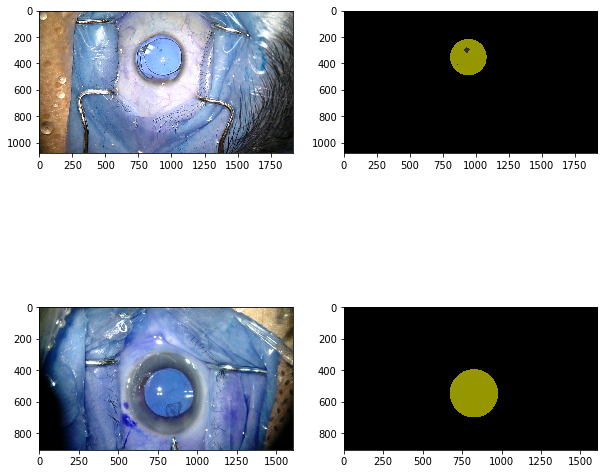

In [4]:


import matplotlib.pyplot as plt
%matplotlib inline
i = 0 
col, row = 2, 2 # hardcoded dimensions.. bad habit. 

fig=plt.figure(figsize=(10, 10))
for image, features in anno.items():
    print('image: ')
    i = i + 1
    name = features['filename']
    img = np.array(cv2.imread(name, cv2.IMREAD_COLOR))
    fig.add_subplot(row, col, i)
    i += 1
    plt.imshow(img)
    mask_demo = np.zeros_like(img)[...,:3] # ignore alpha channel, if it exists
    mask = np.zeros_like(img)[...,:3]
    regions = features['regions']
    for reg in regions:
        attrib = reg['shape_attributes']
        shape = attrib['name']
        obj_name = reg['region_attributes']['name']
        if shape == 'polygon':
            pts = list(zip(attrib['all_points_x'], attrib['all_points_y']))
            print(pts)
            pts = np.array(pts)
            # cv2.fillPoly() accepts a list of polygon pts and draw all of them
            cv2.fillConvexPoly(mask_demo, pts, color_map[obj_name])
            cv2.fillConvexPoly(mask, pts, label_map[obj_name])
        if shape == 'circle':
            cv2.circle(img=mask_demo, center=(attrib['cx'], attrib['cy']), \
                       radius=attrib['r'], color=color_map[obj_name],\
                       thickness=-1) # thickness = -1 sets the method to fill the circle
            cv2.circle(img=mask, center=(attrib['cx'], attrib['cy']), \
                       radius=attrib['r'], color=label_map[obj_name], \
                       thickness=-1)
        if shape == 'point':
            cv2.line(img=mask_demo, pt1=(attrib['cx'], attrib['cy']), \
                     pt2=(attrib['cx'], attrib['cy']), color=color_map[obj_name])
            cv2.line(img=mask, pt1=(attrib['cx'], attrib['cy']), \
                     pt2=(attrib['cx'], attrib['cy']), color=label_map[obj_name])
            
            
    fig.add_subplot(row, col, i)
    plt.imshow(mask_demo)
    path_to_save_color = os.path.join('annotated_color', name)
    if os.path.exists(path_to_save_color):
        os.remove(path_to_save_color)
    Image.fromarray(mask_demo).save(path_to_save_color)
    path_to_save_index = os.path.join('annotated_index', name) # save the binary labeled image with the same name as the raw image
    if os.path.exists(path_to_save_index):
        os.remove(path_to_save_index)
    Image.fromarray(mask).save(path_to_save_index)

plt.show()

(905, 1608, 3)
(1080, 1920, 3)


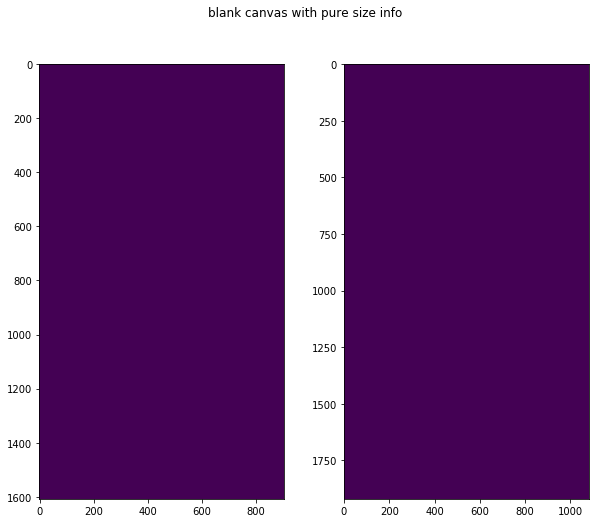

<Figure size 720x576 with 0 Axes>

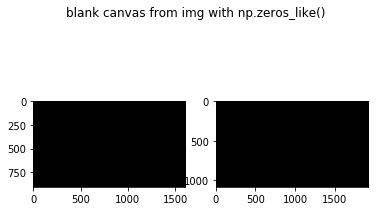

In [5]:
# Difference between np.zeros(img.size) and np.zeros_like(img) 
# I'm not very sure why yet,, please drop me a note if you know what's going on. Thanks! 

fig1 = plt.figure(figsize=(10, 8))
img1 = Image.open('114038-6.png')

mask1 = np.zeros(img1.size)
fig1.add_subplot(1, 2, 1)
plt.imshow(mask1)
img2 = Image.open('2.512138-4png.png')
mask2 = np.zeros(img2.size)
fig1.add_subplot(1, 2, 2)
fig1.suptitle('blank canvas with pure size info')
plt.imshow(mask2)

fig2 = plt.figure(figsize=(10, 8))
fig2 = plt.figure()
img1 = Image.open('114038-6.png')
mask1 = np.zeros_like(img1, dtype='uint8')  # Original datatyle=float64. GG without forcing override. 
mask1 = mask1[...,:3]
print(mask1.shape)
fig2.add_subplot(1, 2, 1)
plt.imshow(mask1)
img2 = Image.open('2.512138-4png.png')
mask2 = np.zeros_like(img2, dtype='uint8')
print(mask2.shape)
fig2.add_subplot(1, 2, 2)
fig2.suptitle('blank canvas from img with np.zeros_like()')
plt.imshow(mask2)

### <span style="color: #009999"> Chapter II: Create a tfrecord </span>

   Take a look at build_data.py 

In [6]:
# Chapter II: convert to tfrecord 
import collections
import six
import tensorflow as tf
import math
import os.path
import sys
import build_data
import tensorflow as tf

In [21]:
FLAGS = tf.app.flags.FLAGS
img_folder = './train'
segmentation_folder = './annotated_index'
list_folder = './lists'
output_dir = './tfrecord'

def _convert_dataset(dataset_split):
    dataset = os.path.basename(dataset_split)[:-4]
    sys.stdout.write('Processing ' + dataset)
    filenames = [x.strip('\n') for x in open(dataset_split, 'r')]
    num_images = len(filenames)
    print(num_images)
    image_reader = build_data.ImageReader('png', channels=3)
    label_reader = build_data.ImageReader('png', channels=1)

    output_filename = os.path.join(output_dir,
        '%s-%02d.tfrecord' % (dataset, 1))
    with tf.python_io.TFRecordWriter(output_filename) as tfrecord_writer:
        for i in range(num_images):
            sys.stdout.write('\r>> Converting image %d of /%d' % (
                i + 1, len(filenames)))
            sys.stdout.flush()
            # Read the image.
            image_filename = os.path.join(
                img_folder, filenames[i])
            print('file_name=', image_filename)
            image_data = tf.gfile.FastGFile(image_filename, 'rb').read()
            height, width = image_reader.read_image_dims(image_data)
            # Read the semantic segmentation annotation.
            seg_filename = os.path.join(
                segmentation_folder, filenames[i])
            seg_data = tf.gfile.FastGFile(seg_filename, 'rb').read()
            seg_height, seg_width = label_reader.read_image_dims(seg_data)
            if height != seg_height or width != seg_width:
                raise RuntimeError('Shape mismatched between image and label.')
            # Convert to tf example.
            example = build_data.image_seg_to_tfexample(
                image_data, filenames[i], height, width, seg_data)
            tfrecord_writer.write(example.SerializeToString())
    sys.stdout.write('\n')
    sys.stdout.flush()

dataset_splits = tf.gfile.Glob(os.path.join(list_folder, '*.txt'))
for dataset_split in dataset_splits:
    print(dataset_split)
    _convert_dataset(dataset_split)

./lists/train.txt
Processing train2
>> Converting image 1 of /2file_name= ./train/2.512138-4png.png
>> Converting image 2 of /2file_name= ./train/114038-6.png



## References
* [Official documentation from Google](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/using_your_own_dataset.md)
* [A concise explaination of what tfrecord is](https://jongwook.kim/blog/Anatomy-of-TFRecord.html)